In [1]:
# 
import re
import sys
from pathlib import Path

#
import PIL
import timm
import nncf
import ipywidgets as widgets
sys.path.append("DeepSeek-VL2")
# 

from ov_deepseek_vl_helper import (
    model_ids,
    convert_deepseek_vl,
    OVDeepseekVLV2ForCausalLM,
)
from deepseek_vl2.models import DeepseekVLV2Processor
from deepseek_vl2.serve.app_modules.presets import BOX2COLOR
from notebook_utils import device_widget


model_selector = widgets.Dropdown(options=model_ids, value=model_ids[0], description="Model")

model_selector
to_compress = widgets.Checkbox(value=True, description="Compression")
to_compress

model_path = Path(model_selector.value.split("/")[-1]) / ("FP16" if not to_compress.value else "INT4")


device = device_widget(default="CPU", exclude=["NPU"])

device

# 
ov_model = OVDeepseekVLV2ForCausalLM(model_path, device.value)
processor = DeepseekVLV2Processor.from_pretrained(model_path)
# 

def parse_ref_bbox(response, image: PIL.Image.Image):
    try:
        image = image.copy()
        image_h, image_w = image.size
        draw = PIL.ImageDraw.Draw(image)

        ref = re.findall(r"<\|ref\|>.*?<\|/ref\|>", response)
        bbox = re.findall(r"<\|det\|>.*?<\|/det\|>", response)
        assert len(ref) == len(bbox)

        if len(ref) == 0:
            return None

        boxes, labels = [], []
        for box, label in zip(bbox, ref):
            box = box.replace("<|det|>", "").replace("<|/det|>", "")
            label = label.replace("<|ref|>", "").replace("<|/ref|>", "")
            box = box[1:-1]
            for onebox in re.findall(r"\[.*?\]", box):
                boxes.append(eval(onebox))
                labels.append(label)

        for indice, (box, label) in enumerate(zip(boxes, labels)):
            box = (
                int(box[0] / 999 * image_h),
                int(box[1] / 999 * image_w),
                int(box[2] / 999 * image_h),
                int(box[3] / 999 * image_w),
            )

            box_color = BOX2COLOR[indice % len(BOX2COLOR.keys())]
            box_width = 3
            draw.rectangle(box, outline=box_color, width=box_width)

            text_x = box[0]
            text_y = box[1] - 20
            text_color = box_color
            font = PIL.ImageFont.truetype("DeepSeek-VL2/deepseek_vl2/serve/assets/simsun.ttc", size=20)
            draw.text((text_x, text_y), label, font=font, fill=text_color)

        return image
    except Exception:
        return None


Python version is above 3.10, patching the collections module.
Add pad token = ['<｜▁pad▁｜>'] to the tokenizer
<｜▁pad▁｜>:2
Add image token = ['<image>'] to the tokenizer
<image>:128815
Add grounding-related tokens = ['<|ref|>', '<|/ref|>', '<|det|>', '<|/det|>', '<|grounding|>'] to the tokenizer with input_ids
<|ref|>:128816
<|/ref|>:128817
<|det|>:128818
<|/det|>:128819
<|grounding|>:128820
Add chat tokens = ['<|User|>', '<|Assistant|>'] to the tokenizer with input_ids
<|User|>:128821
<|Assistant|>:128822



In [2]:
from transformers import TextStreamer
import psutil
import threading
import time
import matplotlib.pyplot as plt

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Question: 
Please identify the giraffe at the back in the image. Describe its location clearly as if you were guiding a visually impaired person, like a navigation system


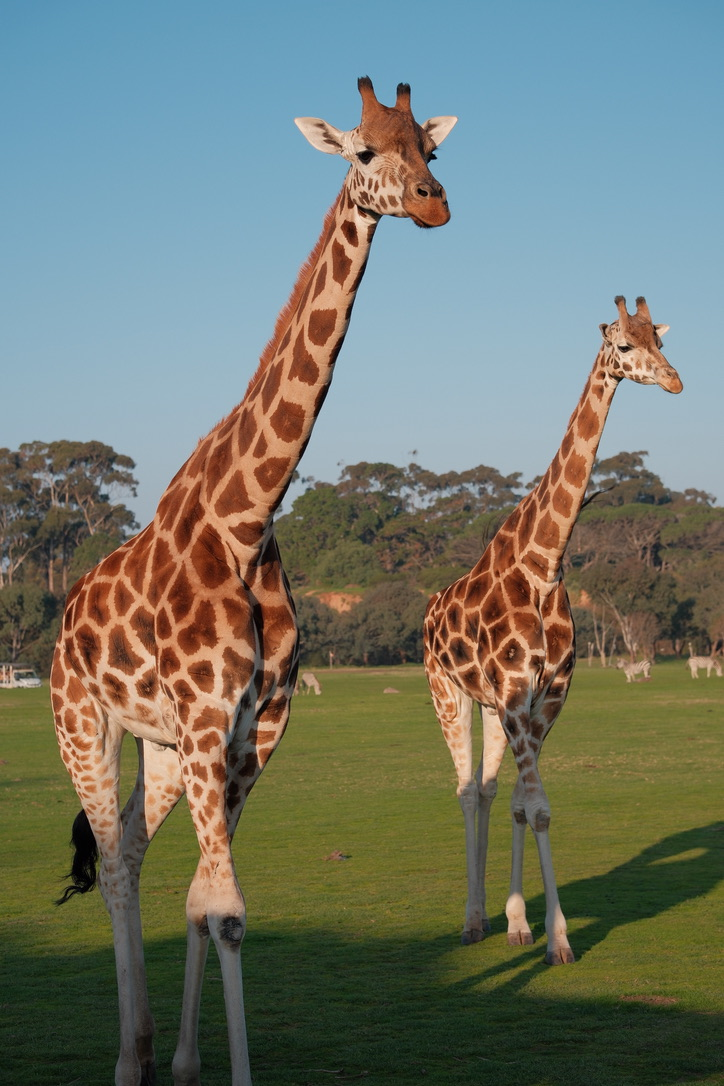

Answer:
The giraffe located behind the other one is positioned slightly further away from the camera's perspective compared to the foreground giraffe. It stands more towards the right side of the frame when viewed from this angle. The background features an open grassy field with trees scattered around, suggesting that it might be part of a larger savanna or wildlife reserve setting. There appears to be another animal visible in the distance near some bushes, but due to the focus being primarily on the two giraffes, details about this secondary subject remain indistinct.


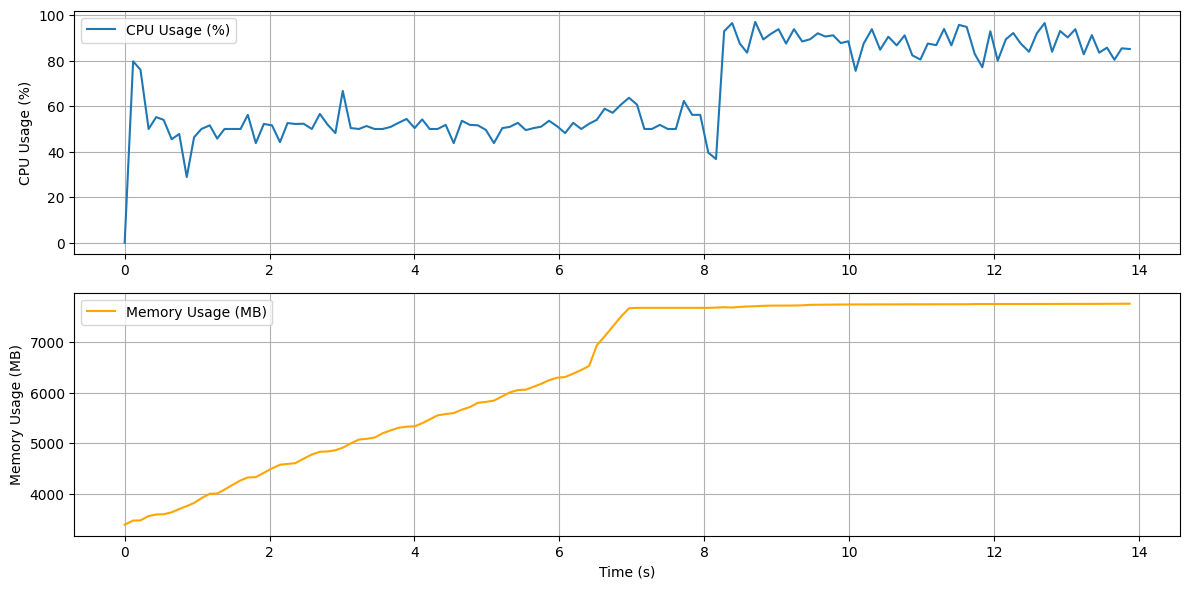

In [3]:

def load_pil_images(conversations):
    """

    Args:
        conversations (List[Dict[str, str]]): the conversations with a list of messages. An example is :
            [
                {
                    "role": "User",
                    "content": "<image>\nExtract all information from this image and convert them into markdown format.",
                    "images": ["./examples/table_datasets.png"]
                },
                {"role": "Assistant", "content": ""},
            ]

    Returns:
        pil_images (List[PIL.Image.Image]): the list of PIL images.

    """

    pil_images = []

    for message in conversations:
        if "images" not in message:
            continue

        for image_path in message["images"]:
            pil_img = PIL.Image.open(image_path)
            pil_img = pil_img.convert("RGB")
            pil_images.append(pil_img)

    return pil_images
    # 여기가 프롬포트 그리고 사진
conversation = [
    {
        "role": "<|User|>",
        "content": "<image>\nPlease identify the giraffe at the back in the image. Describe its location clearly as if you were guiding a visually impaired person, like a navigation system",
        "images": ["DeepSeek-VL2/images/visual_grounding_1.jpeg"],
    },
    {"role": "<|Assistant|>", "content": ""},
]

pil_images = load_pil_images(conversation)
prepare_inputs = processor(conversations=conversation, images=pil_images, force_batchify=True, system_prompt="")
print(f"Question: {conversation[0]['content'].replace('<image>', '')}")
display(pil_images[-1])
inputs_embeds = ov_model.prepare_inputs_embeds(**prepare_inputs)
print("Answer:")

# 모델의 입력 범위를 자세히 하기위해 추가
attention_mask = prepare_inputs["attention_mask"]


## 측정 시작
cpu_usages = []
memory_usages = []
timestamps = []
process = psutil.Process()
monitoring = True
def monitor_system():
    while monitoring:
        cpu_usages.append(psutil.cpu_percent(interval=None))
        memory_usages.append(process.memory_info().rss / (1024 ** 2))  # MB
        timestamps.append(time.time())
        time.sleep(0.1)  # 0.1초 간격으로 기록
monitor_thread = threading.Thread(target=monitor_system)
monitor_thread.start()
start_time = time.time()
##


outputs = ov_model.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=attention_mask,
    pad_token_id=processor.tokenizer.eos_token_id,
    bos_token_id=processor.tokenizer.bos_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    past_key_values=None,
    input_ids=None,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
    streamer=TextStreamer(processor.tokenizer, skip_special_tokens=True),
)
## 측정 끝
end_time = time.time()
monitoring = False
monitor_thread.join()
timestamps = [t - start_time for t in timestamps]
##


answer = processor.tokenizer.batch_decode(outputs, skip_special_tokens=False)

vg_image = parse_ref_bbox(answer[0], image=pil_images[-1])

if vg_image is not None:
    display(vg_image)
    
## 측정용 그래프 제작
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(timestamps, cpu_usages, label='CPU Usage (%)')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(timestamps, memory_usages, label='Memory Usage (MB)', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Memory Usage (MB)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
##